In [1]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

In [13]:
import tensorflow as tf
tf.config.list_physical_devices('GPU') 
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
train_dir = "chest_xray/train"
test_dir = "chest_xray/test"
val_dir = "chest_xray/val"
num_pneumonia = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
num_normal = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia = os.listdir("chest_xray/train/PNEUMONIA")
pneumonia_dir = "chest_xray/train/PNEUMONIA"
normal = os.listdir("chest_xray/train/NORMAL")
normal_dir = "chest_xray/train/NORMAL"

In [3]:
from keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    samplewise_center=True,
    samplewise_std_normalization=True
)
train = image_generator.flow_from_directory(train_dir, 
                                            batch_size=8, 
                                            shuffle=True, 
                                            class_mode='binary',
                                            target_size=(180, 180))

validation = image_generator.flow_from_directory(val_dir, 
                                                batch_size=1, 
                                                shuffle=False, 
                                                class_mode='binary',
                                                target_size=(180, 180))

test = image_generator.flow_from_directory(test_dir, 
                                            batch_size=1, 
                                            shuffle=False, 
                                            class_mode='binary',
                                            target_size=(180, 180))

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [4]:
train_dataset = tf.data.Dataset.from_generator(lambda: train,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
train_dataset = train_dataset.repeat()


validation_dataset = tf.data.Dataset.from_generator(lambda: validation,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
validation_dataset = validation_dataset.repeat()


test_dataset = tf.data.Dataset.from_generator(lambda: test,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, 180, 180, 3], [None]))
test_dataset = test_dataset.repeat()

In [5]:
# Class weights

weight_for_0 = num_pneumonia / (num_normal + num_pneumonia)
weight_for_1 = num_normal / (num_normal + num_pneumonia)

class_weight = {0: weight_for_0, 1: weight_for_1}

In [6]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Flatten, BatchNormalization


model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(180, 180, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))#Dropout

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 178, 178, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 178, 178, 64)     256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 176, 176, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 176, 176, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 88, 88, 64)       0         
 )                                                               
                                                        

In [7]:
layers = model.layers
print(f"The model has {len(layers)} layers")

The model has 19 layers


In [8]:
r = model.fit(
    train_dataset, 
    epochs=10,
    validation_data=validation_dataset, 
    class_weight=class_weight,
    steps_per_epoch=200,
    validation_steps=40,
)

Epoch 1/10
200/200 [==============================] - 777s 4s/step - loss: 4.0232 - accuracy: 0.7569 - val_loss: 87.9829 - val_accuracy: 0.4000
Epoch 2/10
200/200 [==============================] - 798s 4s/step - loss: 1.7213 - accuracy: 0.7894 - val_loss: 9.8492 - val_accuracy: 0.5500
Epoch 3/10
200/200 [==============================] - 795s 4s/step - loss: 0.7415 - accuracy: 0.8338 - val_loss: 26.4505 - val_accuracy: 0.4250
Epoch 4/10
200/200 [==============================] - 770s 4s/step - loss: 0.6378 - accuracy: 0.8006 - val_loss: 4.2007 - val_accuracy: 0.6500
Epoch 5/10
200/200 [==============================] - 760s 4s/step - loss: 0.4903 - accuracy: 0.8119 - val_loss: 8.3227 - val_accuracy: 0.4750
Epoch 6/10
200/200 [==============================] - 777s 4s/step - loss: 0.2653 - accuracy: 0.8256 - val_loss: 2.0670 - val_accuracy: 0.6500
Epoch 7/10
200/200 [==============================] - 797s 4s/step - loss: 0.2249 - accuracy: 0.8300 - val_loss: 1.3749 - val_accuracy: 0.60

Text(0.5, 1.0, 'Accuracy Evolution')

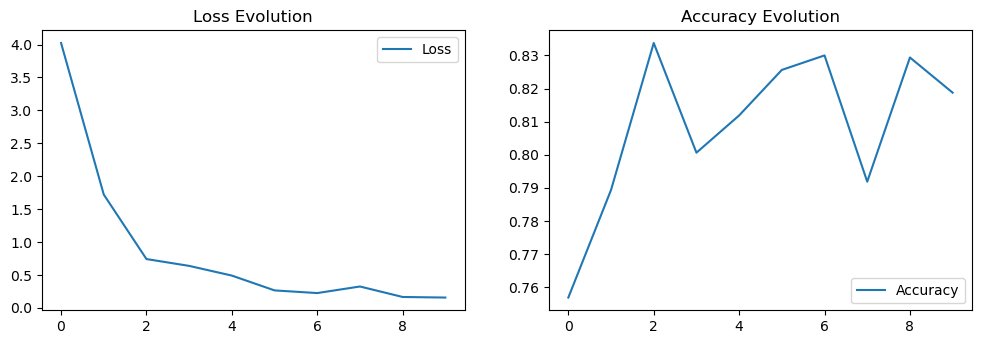

In [9]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
#plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
#plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')

In [10]:
evaluation = model.evaluate(test)
print(f"Test Accuracy: {evaluation[1] * 100:.2f}%")

evaluation = model.evaluate(train)
print(f"Train Accuracy: {evaluation[1] * 100:.2f}%")

624/624 [==============================] - 77s 122ms/step - loss: 1.0043 - accuracy: 0.6891
Test Accuracy: 68.91%
652/652 [==============================] - 522s 801ms/step - loss: 0.4805 - accuracy: 0.8520
Train Accuracy: 85.20%


In [15]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

pred = model.predict(test)

conf_mat = confusion_matrix(test.classes, pred > 0.5)
print(conf_mat)

class_report = classification_report(test.classes, pred > 0.5, output_dict=True)
class_report_df = pd.DataFrame(class_report).transpose()
print(class_report_df)



624/624 [==============================] - 20s 32ms/step
[[ 45 189]
 [  1 389]]
              precision    recall  f1-score     support
0              0.978261  0.192308  0.321429  234.000000
1              0.673010  0.997436  0.803719  390.000000
accuracy       0.695513  0.695513  0.695513    0.695513
macro avg      0.825636  0.594872  0.562574  624.000000
weighted avg   0.787479  0.695513  0.622860  624.000000


In [16]:
model.save('my_model_sq.h5')